In [10]:
import torch
from tqdm import tqdm

# ImageNet

The [ImageNet](http://www.image-net.org/) dataset is one of the main datasets used in image recognition. It contains more than 14 million images annotated according to the hierarchical structure of the [WordNet](https://wordnet.princeton.edu/) dataset.
Images are organized into classes and subclasses having semantic relationships, for example 'car' and 'plane' are 'vehicles', 'cat' and 'bird' are 'animals', 'plane' and 'bird' are 'flying objects', etc ...

ImageNet was accompanied by the challenge: 'Large Scale Visual Recognition Challenge' (ILSVRC), each edition offers different challenges (classification, detection, segmentation, ...) based on a subset of the dataset.

The advantage of having large datasets for learning is to be able to train networks on fairly general tasks, and after reuse the  learned weights for other applications. This operation is called transfer learning. A deep neural network (DNN) learns more and more abstract (hence high-level) features as one progresses through the layers.

Thus, a neural network (NN) pre-trained on a large dataset has low-level characteristics (learned in the first layers) potentially transferable to many tasks. These include texture, color, etc.  An immediate advantage is saving time as one does not have to re-train the NN for every new task from scratch. Another advantage is the fact that the models obtained are more robust. Indeed, a network pre-trained on a complete, large-scale dataset needs on the one hand fewer examples (since it has already seen a lot of them during the first training), and has less risk of over-learning the low level characteristics.

# AlexNet

In 2012, the [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) architecture won the ImageNet competition. The name comes from the first author Alex Krizhevsky. It is a CNN that classifies images into 1000 categories by producing a probability distribution over 1000 classes for each image. The metric used is the percentage of error among the *k* most probable classes (*top-k* error), i.e., we look to see if the true/correct prediction is among the *k* most probable classes predicted by the algorithm.
AlexNet got a top-5 error of 15.3% versus 26.2% for the second best result. This remarkable success led to the adoption of DNNs for the last decade.

Recall that a convolution takes as input a tensor of rank 3 whose first two axes are indexed according to the coordinates of the pixels ($W$, $H$ for width and height) and the last axis stores the channels (for RGB images this is 3). The convolutional kernel is a rank $4$ tensor whose first two axes are indexed according to the coordinates of the pixels supporting the kernel and the last two axes store a matrix of size $d_{in} \times d_{out}$ , where $d_{in}$ is the dimension of the features before convolution, and $d_{out}$ the dimension after the convolution, which will be applied to the input. 

The AlexNet architecture is illustrated in the following diagram:

![](https://drive.google.com/uc?export=view&id=1qXGfYOJRU0pgCcGydat0u2Y9csso9nIQ)

Images are represented by volumes whose height and width are the dimensions of the image and the depth is the number of channels. The size of the convolutional kernel is indicated by the small squares. For instance, we see that the input image is an RGB image of size 224 by 224 and that the first filter has a size of 11 by 11, its input dimension is 3 and its output dimension is 64.

### Question 10: 
Implement the AlexNet architecture. 
You will complete the following code:

In [1]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size= 11,
                stride= 4,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size= 3, 
                stride= 2
            ),
            nn.Conv2d(
                in_channels=64,
                out_channels= 192 ,
                kernel_size= 5,
                padding= 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3,
                stride = 2
            ),
            nn.Conv2d(
                in_channels= 192, 
                out_channels= 384,
                kernel_size= 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels= 384,
                out_channels= 256,
                kernel_size= 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels= 256,
                out_channels= 256,
                kernel_size= 3,
                padding=1
            ),
            nn.ReLU()
            
		)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


Note that some information does not appear on the diagram: 
* the activations are ReLu
* every convolution or fully connected layer is followed by an activation. 

Recall the convolution and pooling operations: for an image of size *h* with a filter of size *k*, padding of *p* and stride of *s* the output size is:

$$ \frac{h-k+2p}{s} + 1 $$

In AlexNet the convolutional layers have a stride of 1 (except the 1st) and the pooling layers have a 'kernel' of size 3 and stride 2. 

Finally, recall the adaptive average pooling function (that performs adaptive pooling), which renders an "image" of predefined size (here 6 by 6). You need to deduce the missing parameters to implement the network described in the diagram above.

# Transfer Learning 

Note that the above AlexNet architecture has two distinct parts:  
* a first "features" sub-network, responsible for extracting relevant characteristics from the image, and
* a "classifier" that is applied on top (i.e., the fully connected layers) 

The "features" part is reusable for *other* tasks. We will import a pre-trained model on ImageNet for the AlexNet architecture. We will then use the corresponding "features" for another classification problem.

We will use the following script defining a "classifier" and applying it to AlexNet features, pre-trained or not.

In [2]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def alexnet_classifier(num_classes):
    classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, num_classes),
    )
    return classifier


def alexnet(num_classes, pretrained=False, **kwargs):
    """AlexNet model architecture from the "One weird trick..." 
    <https://arxiv.org/abs/1404.5997> paper.
    
    Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
        for p in model.features.parameters():
            p.requires_grad=False
    classifier = alexnet_classifier(num_classes)
    model.classifier = classifier

    return model

We will compare the pre-trained model to a non-pretrained model on the CIFAR-10 dataset. This is a much smaller dataset than ImageNet but still very useful for evaluating models while avoiding long training times. It contains 60,000 images (50,000 training, 10,000 test) of size 32 by 32 split into 10 classes. Note that gradient descent has been disabled for pre-trained feature weights to avoid corrupting them during training.

We will load the dataset with the following script:

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
     

batch_size = 64

idx_train = np.arange(50000)
np.random.shuffle(idx_train)
idx_train = idx_train[:1000]

trainset = torchvision.datasets.CIFAR10(
    root="../data", 
    train=True, 
    transform=transform, 
    download=True
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    sampler=SubsetRandomSampler(idx_train)
)

idx_test = np.arange(10000)
np.random.shuffle(idx_test)
idx_test = idx_test[:1000]

testset = torchvision.datasets.CIFAR10(
    root="../data", 
    train=False, 
    transform=transform, 
    download=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)


100%|██████████| 170498071/170498071 [00:09<00:00, 17325058.53it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

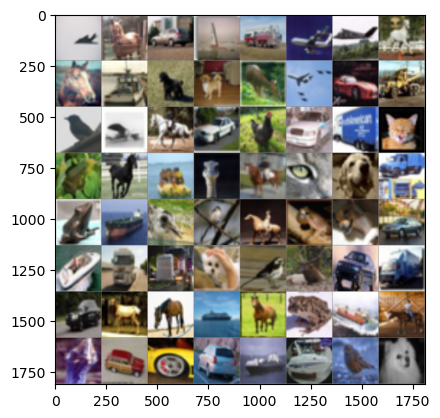

In [4]:
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

You will be able to display the filters of the first convolutional layer, and compare these filters for the pre-trained network and the one trained on CIFAR-10, by viewing them with the following script:

In [5]:
def imshow_filters(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_weights(MyModel ):
  """Displays the filters of the 1st convolutional layer
  of the input model 
  Input:
  - MyModel: the input model
  """
  ii = 0
  filter = MyModel.features[ii].weight.cpu().data
  #Normalizing the values to [0,1]
  f_min, f_max = filter.min(), filter.max()
  filter = (filter - f_min) / (f_max - f_min)
  print("The filter shape is {}".format(filter.shape))
  imshow_filters(torchvision.utils.make_grid(filter))


We have intentionally reduced the size of the images to speed up training. Note that AlexNet being is designed for images of size 224 by 224, we apply a scaling transformation (by the bilinear interpolation method, seen in TD2).

In the following, we will use the following training loop:

In [6]:
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  
  return 100.0 * correct

In [7]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  total = 0
  for epoch in tqdm(range(n_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):

          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          
          # zero the parameter gradients
          optimizer.zero_grad()

          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)

          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
      
  print('Finished Training')

In [ ]:
###

### Question 11
Run the following code and compare the performance between (i) the model and (ii) its pre-trained version. Specifically, compare the filters of the first convolutional layers.

[1,    10] loss: 0.034
[1,    10] acc: 0.078
[2,    10] loss: 0.034
[2,    10] acc: 0.119
[3,    10] loss: 0.033
[3,    10] acc: 0.141
[4,    10] loss: 0.031
[4,    10] acc: 0.175
[5,    10] loss: 0.031
[5,    10] acc: 0.181
[6,    10] loss: 0.031
[6,    10] acc: 0.172
[7,    10] loss: 0.029
[7,    10] acc: 0.217
[8,    10] loss: 0.029
[8,    10] acc: 0.237
[9,    10] loss: 0.028
[9,    10] acc: 0.224
[10,    10] loss: 0.027
[10,    10] acc: 0.263
[11,    10] loss: 0.028
[11,    10] acc: 0.251
[12,    10] loss: 0.028
[12,    10] acc: 0.262
[13,    10] loss: 0.026
[13,    10] acc: 0.273
[14,    10] loss: 0.027
[14,    10] acc: 0.255
[15,    10] loss: 0.025
[15,    10] acc: 0.303
[16,    10] loss: 0.026
[16,    10] acc: 0.253
[17,    10] loss: 0.024
[17,    10] acc: 0.341
[18,    10] loss: 0.023
[18,    10] acc: 0.371
[19,    10] loss: 0.023
[19,    10] acc: 0.329
[20,    10] loss: 0.022
[20,    10] acc: 0.386
[21,    10] loss: 0.021
[21,    10] acc: 0.379
[22,    10] loss: 0.023
[22,   

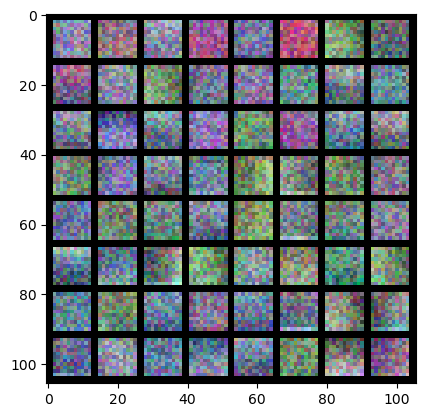

Accuracy of the network on the test images: 38 %


389600.0

In [11]:
# This is the main part where you run the training and test loops and compute accuracy
net = alexnet(num_classes=10, pretrained=False)

use_cuda = False
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(
    net, 
    optimizer, 
    trainloader, 
    testloader, 
    criterion,  
    n_epoch = 50,
    train_acc_period = 10,
    test_acc_period = 1000,
    cuda=use_cuda
)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/pedro/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 91.5MB/s] 


[1,    10] loss: 0.033
[1,    10] acc: 0.182
[2,    10] loss: 0.026
[2,    10] acc: 0.357
[3,    10] loss: 0.022
[3,    10] acc: 0.416
[4,    10] loss: 0.017
[4,    10] acc: 0.533
[5,    10] loss: 0.015
[5,    10] acc: 0.542
[6,    10] loss: 0.013
[6,    10] acc: 0.637
[7,    10] loss: 0.010
[7,    10] acc: 0.690
[8,    10] loss: 0.008
[8,    10] acc: 0.726
[9,    10] loss: 0.008
[9,    10] acc: 0.719
[10,    10] loss: 0.006
[10,    10] acc: 0.765
[11,    10] loss: 0.006
[11,    10] acc: 0.728
[12,    10] loss: 0.004
[12,    10] acc: 0.804
[13,    10] loss: 0.004
[13,    10] acc: 0.800
[14,    10] loss: 0.004
[14,    10] acc: 0.816
[15,    10] loss: 0.004
[15,    10] acc: 0.792
[16,    10] loss: 0.003
[16,    10] acc: 0.819
[17,    10] loss: 0.003
[17,    10] acc: 0.814
[18,    10] loss: 0.002
[18,    10] acc: 0.834
[19,    10] loss: 0.002
[19,    10] acc: 0.840
[20,    10] loss: 0.002
[20,    10] acc: 0.829
[21,    10] loss: 0.002
[21,    10] acc: 0.848
[22,    10] loss: 0.002
[22,   

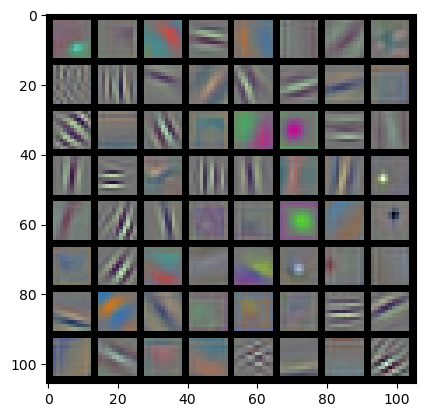

Accuracy of the network on the test images: 68 %


685500.0

In [12]:
# This is the main part where you run the training and test loops and compute accuracy
net = alexnet(num_classes=10, pretrained=True)

use_cuda = False
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(
    net, 
    optimizer, 
    trainloader, 
    testloader, 
    criterion,  
    n_epoch = 50,
    train_acc_period = 10,
    test_acc_period = 1000,
    cuda=use_cuda
)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)